# Sentence Piece

아마 여러분들은 네이버 영화리뷰 감정분석 태스크를 한 번쯤은 다루어 보았을 것입니다. 한국어로 된 corpus를 다루어야 하므로 주로 KoNLPy에서 제공하는 형태소 분석기를 사용하여 텍스트를 전처리해서 RNN 모델을 분류기로 사용했을 것입니다.

만약 이 문제에서 tokenizer를 sentencepiece로 바꾸어 다시 풀어본다면 더 성능이 좋아질까요? 비교해 보는 것도 흥미로울 것입니다.

    네이버 영화리뷰 감정분석 코퍼스에 sentencepiece를 적용시킨 모델 학습하기

    학습된 모델로 sp_tokenize() 메소드 구현하기

    구현된 토크나이저를 적용하여 네이버 영화리뷰 감정분석 모델을 재학습하기

    KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기

    (보너스) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

    Word Vector는 활용할 필요가 없습니다. 활용이 가능하지도 않을 것입니다.

    머지않아 SentencePiece와 BERT 등의 pretrained 모델을 함께 활용하는 태스크를 다루게 될 것입니다.


# 데이터 불러오기

In [280]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import konlpy
import os
import tensorflow as tf

# 데이터를 읽어봅시다. 
train_file = os.getenv('HOME') + '/aiffel/sentencepiece/ratings_train.txt'
test_file =  os.getenv('HOME') + '/aiffel/sentencepiece/ratings_test.txt'
train_data = pd.read_csv(train_file, sep = '\t', quoting = 3)
test_data = pd.read_csv(test_file, sep = '\t', quoting = 3)
print(train_data.shape)
print(test_data.shape)

(150000, 3)
(50000, 3)


In [281]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 중복 데이터 제거

In [282]:
train_data = train_data.drop_duplicates(['document'])
test_data = test_data.drop_duplicates(['document'])
X_train = train_data['document']
y_train = train_data['label']
X_test = test_data['document']
y_test = test_data['label']

In [283]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(146183,)
(146183,)
(49158,)
(49158,)


## 결측치 확인 및 제거

In [284]:
train_data = train_data.dropna().reset_index(drop = True)

In [285]:
test_data = test_data.dropna().reset_index(drop = True)

### ㄴ 데이터에 결측치가 있어 제거해준다. 결측치가 존재하면 for loop에서 에러가 난다.

## 데이터 전처리
---
### 길이가 5이상, 100미만인 문장들만 추출하여 corpus를 재생성한다.
### 노드에 있는 함수를 그대로 쓰면 리뷰 (document열)는 필터링이 되는 반면 Label은 필터링이 안되어 학습시 차원수가 맞지 않아 Epoch이 안돌아간다.
### 때문에 필터링되는 리뷰에 상응하는 label도 처리될수 있는 함수를 짜주었다.

In [286]:
train_document = []
for i in range(len(train_data['document'])):
    if 5 < len(train_data['document'][i]) & len(train_data['document'][i]) < 100:
        train_document.append(train_data['document'][i])
    else: continue
X_train = train_document
        

In [287]:
train_label = []
for i in range(len(train_data['document'])):
    if 5 < len(train_data['document'][i]) & len(train_data['document'][i]) < 100:
        train_label.append(int(train_data['label'][i]))
    else: continue
y_train = np.array(train_label) # 모델 학습을 위해 List가 아닌 Array로 지정

In [288]:
test_document = []
for i in range(len(test_data['document'])):
    if 5 < len(test_data['document'][i]) & len(test_data['document'][i]) < 100:
        test_document.append(test_data['document'][i])
    else: continue
X_test = test_document 

In [289]:
test_label = []
for i in range(len(test_data['document'])):
    if 5 < len(test_data['document'][i]) & len(test_data['document'][i]) < 100:
        test_label.append(int(test_data['label'][i]))
    else: continue
y_test = np.array(test_label) # 모델 학습을 위해 List가 아닌 Array로 지정

## Sentence Piece 학습

## Train Data 학습

In [290]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in X_train:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw-rw-r-- 1 aiffel-dj53 aiffel-dj53 375273  4월 20 17:15 korean_spm.model
-rw-rw-r-- 1 aiffel-dj53 aiffel-dj53 144583  4월 20 17:15 korean_spm.vocab


In [291]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1520, 10, 407, 15, 1386, 10, 139, 17, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


## sp_tokenize 함수

In [292]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [293]:
X_train, word_index, index_word = sp_tokenize(s, X_train)

In [294]:
print(X_train)

[[  58  869    5 ...    0    0    0]
 [1580    8 4726 ...    0    0    0]
 [  22  376 7752 ...    0    0    0]
 ...
 [ 132  169   55 ...    0    0    0]
 [1828  716 4832 ...    0    0    0]
 [ 272    7 4010 ...    0    0    0]]


In [295]:
print(y_train[0])

0


### ㄴ 정수화된 tensor값들이 나열됐다.

In [296]:
print(s.encode('진짜 최고의 영화입니다 ㅋㅋ', out_type=str))
print(s.encode('진짜 최고의 영화입니다 ㅋㅋ', out_type=int))

['▁진짜', '▁최고의', '▁영화입니다', '▁ᄏᄏ']
[31, 96, 608, 93]


## Test Data 학습

In [297]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 2000

with open(temp_file, 'w') as f:
    for row in X_test:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw-rw-r-- 1 aiffel-dj53 aiffel-dj53 262971  4월 20 17:15 korean_spm.model
-rw-rw-r-- 1 aiffel-dj53 aiffel-dj53  27024  4월 20 17:15 korean_spm.vocab


In [298]:
X_test, word_index, index_word = sp_tokenize(s, X_test)

In [299]:
print(X_test[0])

[4456 1286 3163 2004 2897 2414 2438 4899 2944 2258 2258 3617 3163 2004
 4180 2045 2438 4899 4260 2769    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]


## Validation 생성

In [300]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

In [301]:
partial_X_train.shape

(124062, 80)

In [302]:
partial_y_train.shape

(124062,)

## 모델 학습

In [303]:

total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  79.7489371686508
문장길이 최대 :  80
문장길이 표준편차 :  0.43362459116627694
pad_sequences maxlen :  80
전체 문장의 1.0%가 maxlen 설정값 이내에 포함됩니다. 


In [304]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
# [[YOUR CODE]]
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [305]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs= 4  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/4
243/243 [==============================] - 2s 7ms/step - loss: 0.5183 - accuracy: 0.7330 - val_loss: 0.3434 - val_accuracy: 0.8525
Epoch 2/4
243/243 [==============================] - 2s 6ms/step - loss: 0.3194 - accuracy: 0.8645 - val_loss: 0.3229 - val_accuracy: 0.8619
Epoch 3/4
243/243 [==============================] - 2s 6ms/step - loss: 0.2863 - accuracy: 0.8804 - val_loss: 0.3229 - val_accuracy: 0.8608
Epoch 4/4
243/243 [==============================] - 2s 7ms/step - loss: 0.2600 - accuracy: 0.8946 - val_loss: 0.3334 - val_accuracy: 0.8580


## 평가

In [306]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1405/1405 - 2s - loss: 0.3505 - accuracy: 0.8504
[0.3505465090274811, 0.85038161277771]


### ㄴ 85%정도의 적중률을 보인다

## 학습 시각화

In [307]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


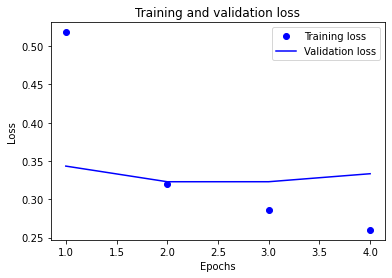

In [308]:

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

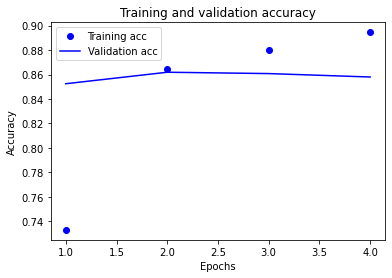

In [309]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 회고
---
## 1. Tokenizing기법중 하나인 SentencePiece를 적용, 학습하는 모델이였다.
## 2. 데이터내에 결측치가 있어 먼저 제거를 하고 전처리를 해야했다. 결측치가 존재하는 상태에서 전처리 for loop을 돌리니 에러가 발생했다.
## 3. 기존 노드에 나와있던 함수를 이용하면, 리뷰(document)는 필터링이 되는 반면 상응하는 Label은 그대로 남아 차원수가 맞지 않아 모델 학습에서 에러가 발생했다.
## 4. for loop을 이용한 함수를 만들어 조건에 만족하는 document와 label을 append하여 데이터 전처리를 진행했다.
## 5. Accuracy를 높혀보려 30이상의 Epochs를 돌려봤지만, training loss와 val loss가 극심하게 엇갈려 결국 4epochs로 진행했다.
## 6. 4 epochs로 학습을 하니 85%정도의 적중률을 보여주었다.